

<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>

<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>

In [1]:
# Install Java and PySpark
!apt-get install openjdk-11-jdk -y
!pip install pyspark

# Install required libraries for modeling
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install datasets transformers accelerate

# Set JAVA_HOME path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define project output path inside Google Drive
drive_output_path = '/content/drive/MyDrive/Colab Notebooks/BDA/AfterPreprocessing'
os.makedirs(drive_output_path, exist_ok=True)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
# # Source to install PyTorch: https://pytorch.org/get-started/locally/
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# To install Locally/Google Colab
! pip install datasets
! pip install transformers
! pip install accelerate

### **PySpark Session**

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_ModellingTransformersColab")
         .config("spark.driver.memory", "15g")              # Adjust memory for driver
         .config("spark.executor.memory", "15g")            # Adjust memory per executor
         .getOrCreate())

# Set Spark configurations for convert to Pandas without errors
# Source: https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 📚 **Libraries Import**

In [ ]:
# Imports for System Operations
import os
import sys
import time
import datetime
import warnings
from typing import Tuple, List, Optional

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Imports PySpark
from pyspark.sql import DataFrame
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Imports for Text Processing
from pyspark.sql.functions import regexp_replace, when, col

# Imports for Machine Learning/Sentiment Analysis
import torch
import transformers
# Source: https://huggingface.co/models
from transformers import pipeline, Pipeline
from datasets import Dataset
from tqdm import tqdm                    # For progress bar

In [4]:
# Source https://github.com/pytorch/torchtune/issues/1185
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [5]:
print(transformers.__version__)
print(torch.__version__)

4.51.3
2.5.1+cu121


In [6]:
torch.cuda.empty_cache()  # You may use this command to clear your cache
torch.cuda.is_available() # You may use this command to check if you have gpu or not
# (if False in Google Colab: Make sure your Hardware accelerator is set to GPU. | Runtime > Change runtime type > Hardware Accelerator)

# automatically chose CPU or GPU for inference, depending on your hardware
device = torch.cuda.current_device() if torch.cuda.is_available() else -1
# -1 == CPU ; 0 == GPU
print(device)

0


---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [7]:
# %sh
# # Create the directory for the dataset
# mkdir -p /databricks/driver/AfterPreprocessing

# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# # Step 1: Fetch the confirmation token and save cookies (Reviews)
# wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Step 2: Read the confirmation token
# confirm_token=$(cat /tmp/confirm.txt)

# # Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
# wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=$confirm_token" \
#   -O /databricks/driver/AfterPreprocessing/df-computers-reviews.zip

# # Step 4: Clean up temporary files
# rm /tmp/cookies.txt /tmp/confirm.txt

In [8]:
# %sh
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# # Step 1: Fetch the confirmation token and save cookies (Products)
# wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Step 2: Read the confirmation token
# confirm_token=$(cat /tmp/confirm.txt)

# # Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
# wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download&confirm=$confirm_token" \
#   -O /databricks/driver/AfterPreprocessing/df-computers-products.zip

# # Step 4: Clean up temporary files
# rm /tmp/cookies.txt /tmp/confirm.txt

In [9]:
# %sh
# # Print the contents of the driver directory
# ls -lh /databricks/driver/

In [10]:
# %sh
# # Unzip the downloaded files
# unzip  /databricks/driver/AfterPreprocessing/df-computers-reviews.zip -d  /databricks/driver/AfterPreprocessing/df-computers-reviews
# unzip  /databricks/driver/AfterPreprocessing/df-computers-products.zip -d  /databricks/driver/AfterPreprocessing/df-computers-products

# # List the unzipped files
# ls -lh  /databricks/driver/AfterPreprocessing/

### **🟨 Google Colab/Locally FileStore**

- If you are using Google Colab or running the notebook locally, you can use the following code to download the dataset.

In [11]:
# Create a directory for the data
!mkdir -p /content/AfterPreprocessing/

In [12]:
# Download the file from Google Drive using wget
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Download the file using the confirmation token and cookies (Reviews)
!wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Read the confirmation token from the temporary file
with open('/tmp/confirm.txt', 'r') as f:
    confirm_token = f.read().strip()

# Download the file using the confirmation token and cookies (Reviews)
!wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm={confirm_token}" \
  -O /content/AfterPreprocessing/df-computers-reviews.zip

# Clean up temporary files
!rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-12 20:49:55--  https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198851642 (190M) [application/octet-stream]
Saving to: ‘/content/AfterPreprocessing/df-computers-reviews.zip’

/content/AfterPrepr 100%[===================>] 189.64M  55.2MB/s    in 3.4s    

2025-05-12 20:50:01 (55.2 MB/s) - ‘/content/AfterPreprocessing/df-computers-reviews.zip’ saved [198851642/198851642]



In [13]:
# Download the file using the confirmation token and cookies (Products)
!wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Read the confirmation token from the temporary file
with open('/tmp/confirm.txt', 'r') as f:
    confirm_token = f.read().strip()

# Download the file using the confirmation token and cookies (Products)
!wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&confirm={confirm_token}" \
  -O /content/AfterPreprocessing/df-computers-products.zip

# Clean up temporary files
!rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-12 20:50:07--  https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5532593 (5.3M) [application/octet-stream]
Saving to: ‘/content/AfterPreprocessing/df-computers-products.zip’

/content/AfterPrepr 100%[===================>]   5.28M  15.3MB/s    in 0.3s    

2025-05-12 20:50:10 (15.3 MB/s) - ‘/content/AfterPreprocessing/df-computers-products.zip’ saved [5532593/5532593]



In [14]:
# List files in the /content directory to verify the download
!ls -lh /content/

# Unzip the downloaded file
!unzip /content/AfterPreprocessing/df-computers-reviews.zip -d /content/AfterPreprocessing/df-computers-reviews
!unzip /content/AfterPreprocessing/df-computers-products.zip -d /content/AfterPreprocessing/df-computers-products

# List the unzipped files to verify
!ls -lh /content/AfterPreprocessing/

total 12K
drwxr-xr-x 2 root root 4.0K May 12 20:50 AfterPreprocessing
drwx------ 7 root root 4.0K May 12 20:48 drive
drwxr-xr-x 1 root root 4.0K May  9 13:41 sample_data
Archive:  /content/AfterPreprocessing/df-computers-reviews.zip
  inflating: /content/AfterPreprocessing/df-computers-reviews/.part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /content/AfterPreprocessing/df-computers-reviews/part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /content/AfterPreprocessing/df-computers-reviews/.part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /content/AfterPreprocessing/df-computers-reviews/.part-00004-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /content/AfterPreprocessing/df-computers-reviews/_SUCCESS  
  inflating: /content/AfterPreprocessing/df-computers-reviews/part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /conte

---

In [15]:
!pwd

/content


### **🧮 PySpark Load Data**

In [16]:
# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | After Preprocessing)

# Read the reviews DataFrame
# reviews_df = spark.read.parquet("./data/AfterPreprocessing/df-computers-reviews")                   # Local Path
# reviews_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-reviews")  # Databricks Path
reviews_df = spark.read.parquet("/content/AfterPreprocessing/df-computers-reviews")                   # Google Colab Path

# Read the products/metadata DataFrame
# products_df = spark.read.parquet("./data/AfterPreprocessing/df-computers-products")                   # Local Path
# products_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-products")  # Databricks Path
products_df = spark.read.parquet("/content/AfterPreprocessing/df-computers-products")                   # Google Colab Path

### **Reviews**

In [17]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", reviews_df.count())
print("\033[1mNumber of Features:\033[0m ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)

-RECORD 0----------------------------
 review_id    | 566434               
 rating       | 5                    
 review_text  | Works perfectly I... 
 parent_asin  | B017RD0WHS           
 user_id      | AELFXU7PGH55CEEUH... 
 helpful_vote | 0                    
 timestamp    | 1664226670519        
 timestamp_dt | 2022-09-26 21:11:10  
 year         | 2022                 
 month        | 9                    
 day          | 26                   
 day_of_week

### **Products/Metadata**

In [18]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", products_df.count())
print("\033[1mNumber of Features:\033[0m ", len(products_df.columns))

root
 |-- meta_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- parent_asin: string (nullable = true)

-RECORD 0-----------------------------------
 meta_title          | Barnes & Noble No... 
 meta_average_rating | 4.0                  
 meta_rating_number  | 12                   
 meta_price          | 147.95               
 meta_store          | Barnes & Noble       
 parent_asin         | 0594149290           
only showing top 1 row


Number of Observations:  59418
Number of Features:  6


# <span style="color: #ffffff;">5 | Modelling</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>5 | Modelling</b></h1></center>
</div>
<br>

In [19]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

### **⚒️ Text Preprocessing**

In [20]:
# Define a function to clean text columns
def clean_text_column(df, column_name):
    """
    Clean the specified text column in the DataFrame by removing unwanted characters and normalizing whitespace.
    Args:
        df (DataFrame): The DataFrame containing the text column to be cleaned.
        column_name (str): The name of the text column to be cleaned.
    Returns:
        DataFrame: The DataFrame with the cleaned text column.
    """
    return df.withColumn(column_name, regexp_replace(col(column_name), "[^a-zA-Z0-9\\s]", "")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\\s+", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\t", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\f", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\v", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\r\r", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\n\n", " ")) \
             .withColumn(column_name, regexp_replace(col(column_name), "\t\t", " "))

    # Regex Explanation:
    #   [^a-zA-Z0-9\\s] - Matches any character that is not a letter, digit, or whitespace
    #   \\s+ -            Matches one or more whitespace characters
    #   \t -              Matches tab characters
    #   \n -              Matches newline characters
    #   \r -              Matches carriage return characters
    #   \f -              Matches form feed characters
    #   \v -              Matches vertical tab characters
    #   \r\n -            Matches carriage return followed by newline characters
    #   \r\r -            Matches two consecutive carriage return characters
    #   \n\n -            Matches two consecutive newline characters
    #   \t\t -            Matches two consecutive tab characters

# Apply the function to the 'review_text' column in reviews_df
reviews_df = clean_text_column(reviews_df, "review_text")

# Apply the function to the 'meta_title' column in products_df
products_df = clean_text_column(products_df, "meta_title")

# <span style="color: #ffffff;">Sentiment Analysis</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #C32A68;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #C32A68;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Sentiment Analysis</b></h2></center>
</div>
<br>

In [21]:
# Color Palette for Sentiment Analysis
sentiment_colors = {'Positive': '#64C548',
                     'Neutral': '#F47131',
                     'Negative': '#CF213D'}

sentiment_colors_full = {'Positive': '#64C548',
                         'Positive Tendency': '#EBA722',
                         'Neutral': '#F47131',
                         'Negative Tendency': '#F03F42',
                         'Negative': '#CF213D'}

In [ ]:
# ============================================
#      Core Classification Functions
# ============================================

# ------------------------------ [Function to Setup Environment] ------------------------------
def setup_environment(output_path: str) -> str:
    """Set up the environment for saving results (Google Colab, Databricks, or local).

    Args:
        output_path: Path to save classification results.

    Returns:
        str: Adjusted output path for the environment.

    Source:
        - Databricks DBFS: https://docs.databricks.com/en/files/index.html
        - Google Colab Drive: https://colab.research.google.com/notebooks/io.ipynb
    """
    if 'google.colab' in sys.modules:
        from google.colab import drive
        if not os.path.exists('/content/drive/MyDrive'):
            print("Mounting Google Drive")
            drive.mount('/content/drive')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        print("Google Colab environment set up")
        return output_path

    if '/databricks/driver' in os.getcwd():
        adjusted_path = f"dbfs:/FileStore/{output_path.lstrip('/')}"
        dbutils.fs.mkdirs(os.path.dirname(adjusted_path))
        print("Databricks environment set up")
        return adjusted_path

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    print("Local environment set up")
    return output_path

# ------------------------------ [Function to Load Processed IDs] ------------------------------
def load_processed_ids(spark: SparkSession, output_path: str, id_col: str) -> set:
    """Load IDs of already processed rows from an existing results file.

    Args:
        spark: Active Spark session.
        output_path: Path to the existing results file.
        id_col: Name of the ID column.

    Returns:
        set: Set of processed IDs.

    Source:
        - Spark CSV Read: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html
    """
    if not os.path.exists(output_path):
        print("No existing results found")
        return set()

    existing_df = spark.read.csv(output_path, sep='\t', header=True, inferSchema=True)
    processed_ids = set(existing_df.select(id_col).rdd.flatMap(lambda x: x).collect())
    print(f"Loaded {len(processed_ids)} processed IDs")
    return processed_ids

# ------------------------------ [Function to Process Batch] ------------------------------
def process_batch(batch: List[dict], pipeline_instance: Pipeline, id_col: str, text_col: str,
                  output_label_col: str, output_score_col: str, candidate_labels: Optional[List[str]] = None) -> List[dict]:
    """Process a batch of rows using the Hugging Face pipeline with Dataset for GPU efficiency.

    Args:
        batch: List of dictionaries containing row data.
        pipeline_instance: Hugging Face pipeline for classification.
        id_col: Name of the ID column.
        text_col: Name of the text column.
        output_label_col: Name of the output label column.
        output_score_col: Name of the output score column.
        candidate_labels: Optional list of labels for zero-shot classification.

    Returns:
        List[dict]: Processed results with labels and scores.

    Source:
        - Hugging Face Datasets: https://huggingface.co/docs/datasets/v2.21.0/en/index
        - Pipeline Batching: https://huggingface.co/docs/transformers/main_classes/pipelines#pipeline-batching
    """
    texts = [row[text_col] for row in batch]
    ids = [row[id_col] for row in batch]

    # Create a Hugging Face Dataset for batched processing (GPU efficiency)
    dataset = Dataset.from_dict({'text': texts})

    # Process the entire batch at once
    if candidate_labels:
        outputs = pipeline_instance(
            dataset['text'],
            candidate_labels=candidate_labels,
            multi_label=False,
            batch_size=len(texts)  # Process all texts in one batch
        )
    else:
        outputs = pipeline_instance(
            dataset['text'],
            batch_size=len(texts)  # Process all texts in one batch
        )

    results = []
    for i, output in enumerate(outputs):
        label = output['labels'][0] if candidate_labels else output['label']
        score = float(output['scores'][0]) if candidate_labels else float(output['score'])
        results.append({
            id_col: ids[i],
            text_col: texts[i],
            output_label_col: label,
            output_score_col: score
        })

    return results

# ------------------------------ [Function to Save Results] ------------------------------
def save_results(spark: SparkSession, results: List[dict], output_path: str, append: bool = True) -> None:
    """Save classification results to a TSV file, optionally appending to existing results.

    Args:
        spark: Active Spark session.
        results: List of result dictionaries.
        output_path: Path to save the results.
        append: If True, append to existing file; if False, overwrite.

    Source:
        - Spark CSV Write: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameWriter.csv.html
    """
    if not results:
        print("No results to save")
        return

    new_results_df = spark.createDataFrame(results)
    mode = "append" if append and os.path.exists(output_path) else "overwrite"

    new_results_df.write.csv(output_path, sep='\t', header=True, mode=mode)
    # print(f"Results saved to {output_path} in {mode} mode")                   # Debugging

# ------------------------------ [Main Classification Function] ------------------------------
def classify_text_spark_incremental(spark: SparkSession, input_df: DataFrame, pipeline_instance: Pipeline,
                                    id_col: str, text_col: str, output_path: str,
                                    output_label_col: str = "Sentiment", output_score_col: str = "Score",
                                    candidate_labels: Optional[List[str]] = None,
                                    batch_size: int = 32, save_interval: int = 1000) -> Tuple[str, int, float]:
    """Classify text data incrementally using Spark and Hugging Face pipeline, saving results every save_interval rows.

    Args:
        spark: Active Spark session.
        input_df: Input Spark DataFrame with ID and text columns.
        pipeline_instance: Hugging Face pipeline for classification.
        id_col: Name of the ID column.
        text_col: Name of the text column.
        output_path: Path to save results.
        output_label_col: Name of the output label column.
        output_score_col: Name of the output score column.
        candidate_labels: Optional list of labels for zero-shot classification.
        batch_size: Number of rows to process per batch.
        save_interval: Number of rows after which to save results (default: 1000).

    Returns:
        Tuple[str, int, float]: Output path, number of processed rows, execution time.

    Source:
        - Spark toLocalIterator: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.toLocalIterator.html
        - Hugging Face Pipeline: https://huggingface.co/docs/transformers/main_classes/pipelines
    """
    start_time = time.time()
    processed_count = 0       # Track processed texts
    save_counter = 0          # Track save intervals

    # Setup environment and adjust output path
    output_path = setup_environment(output_path)

    # Load processed IDs to avoid reprocessing
    processed_ids = load_processed_ids(spark, output_path, id_col)

    # Filter out already processed rows
    # Note: 'broadcast' to avoid not to send the entire list to each executor
    broadcast_ids = spark.sparkContext.broadcast(processed_ids)
    df_to_process = input_df.select(id_col, text_col) \
        .filter(~F.col(id_col).cast("string").isin(broadcast_ids.value))
    total_rows = df_to_process.count()

    if total_rows == 0:
        print("No new rows to process")
        return output_path, 0, time.time() - start_time

    print(f"Processing {total_rows} new rows")

    # Initialize results buffer and iterator
    results_buffer = []
    data_iterator = df_to_process.toLocalIterator(prefetchPartitions=True)
    batch_data = []
    batch_counter = 0  # Track number of batches processed

    with tqdm(total=total_rows, desc="Classifying Text", unit="row") as pbar:
        for row in data_iterator:
            row_dict = row.asDict()
            if (not row_dict.get(text_col) or
                not isinstance(row_dict[text_col], str) or
                row_dict[text_col].strip() == ''):
                pbar.update(1)
                continue

            batch_data.append(row_dict)

            if len(batch_data) >= batch_size:
                # Process the batch
                batch_results = process_batch(
                    batch_data, pipeline_instance, id_col, text_col,
                    output_label_col, output_score_col, candidate_labels
                )
                results_buffer.extend(batch_results)
                processed_count += len(batch_data)
                pbar.update(len(batch_data))

                # Save results if processed_count reaches the next save interval
                if processed_count >= save_interval * (save_counter + 1):
                    save_results(spark, results_buffer, output_path, append=True)
                    processed_ids.update([result[id_col] for result in results_buffer])
                    save_counter += 1
                    # print(f"Saved {processed_count} rows at interval {save_counter} (batch {batch_counter + 1})") # Debugging

                    # Clear the buffer to manage memory
                    results_buffer = []

                batch_data = []
                batch_counter += 1

        # Process any remaining data
        if batch_data:
            batch_results = process_batch(
                batch_data, pipeline_instance, id_col, text_col,
                output_label_col, output_score_col, candidate_labels
            )
            results_buffer.extend(batch_results)
            processed_count += len(batch_data)
            pbar.update(len(batch_data))

        # Save any remaining results
        if results_buffer:
            save_results(spark, results_buffer, output_path, append=True)
            processed_ids.update([result[id_col] for result in results_buffer])
            print(f"Saved final {len(results_buffer)} rows, total processed: {processed_count}")

    execution_time = time.time() - start_time
    print(f"Processed {processed_count} rows in {execution_time:.2f} seconds")
    return output_path, processed_count, execution_time

---


## 🟡 **HuggingFace [twitter-xlm-roberta-base-sentiment-finetunned](https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned)**

In [23]:
# Sentiment Analysis | XLM-RoBERTa
# Source: https://huggingface.co/docs/transformers/main_classes/pipelines
#         https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned
TXRBSF_sentiment_classifier = pipeline("text-classification",                       # Task Name (List Source: https://huggingface.co/tasks)
    model="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned",               # XLM-RoBERTa
    tokenizer="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned",           # XLM-RoBERTa
    max_length=512,                                                                 # Maximum Length of the Input Sequence
    truncation=True,                                                                # Truncate the Input Sequence
    device=device                                                                   # Use the automatically detected device
)

# Function to classify sentiment (Simple Function)
def TXRBSF_classify_sentiment(text):
    # Classify the sentiment
    outputs = TXRBSF_sentiment_classifier(text, batch_size=8)

    # Extract the label and score from the output
    return outputs[0]['label'], outputs[0]['score']


# Example usage (Pipeline & Function)
examples_text = ["This product is amazing! I love it.", "I didn't like this product at all.", "It's okay, not the best but not the worst."]

for text in examples_text:
    print(f"Text: {text}")
    print(f"Pipeline Output: {TXRBSF_sentiment_classifier(text)}")
    print(f"Function Output: {TXRBSF_classify_sentiment(text)}")
    print("\n")

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Text: This product is amazing! I love it.
Pipeline Output: [{'label': 'Positive', 'score': 0.9916386008262634}]
Function Output: ('Positive', 0.9916386008262634)


Text: I didn't like this product at all.
Pipeline Output: [{'label': 'Negative', 'score': 0.982453465461731}]
Function Output: ('Negative', 0.982453465461731)


Text: It's okay, not the best but not the worst.
Pipeline Output: [{'label': 'Negative', 'score': 0.7664964199066162}]
Function Output: ('Negative', 0.7664964199066162)




In [ ]:
# ============================================ APPLY TXRBSF_sentiment_classifier ============================================
# Apply the sentiment classification function to the reviews DataFrame

# 1st Step: Load Hugging Face Pipeline | Sentiment Analysis (Text Classification)
# Already done above

# 2nd Step: Define Output Path on Google Drive
gdrive_output_dir = "/content/drive/MyDrive/AmazonReviews_Results"
sentiment_output_file = os.path.join(gdrive_output_dir, "ReviewsSentiment_TXRBSF.tsv")

# # If we wanna run in Databricks: Using DBFS (Community Edition)
# dbfs_output_dir = "dbfs:/FileStore/AmazonReviews_Results"                                     # Path to save the results
# sentiment_output_file_dbfs = os.path.join(dbfs_output_dir, "ReviewsSentiment_TXRBSF.tsv")
# sentiment_output_file = sentiment_output_file_dbfs

# 3rd Step: Run the Classification Function | Sentiment Analysis
sentiment_path, sentiment_count, sentiment_time = classify_text_spark_incremental(
    spark=spark,
    input_df=reviews_df,                            # Your input Spark DataFrame
    pipeline_instance=TXRBSF_sentiment_classifier,  # Using the sentiment analysis pipeline
    id_col="review_id",                             # 'review_id' is a unique ID for reviews
    text_col="review_text",                         # Column containing the review text
    output_path=sentiment_output_file,              # Path to save the results
    output_label_col="SentimentLabel",              # Column for sentiment labels
    output_score_col="SentimentScore",              # Column for sentiment scores
    batch_size=32,                                  # Batch size for processing
    save_interval=1000                              # Save results every 1000 rows
)

# Verify Output
results_sentiment_spark = spark.read.csv(sentiment_path, sep='\t', header=True, inferSchema=True)
print(f"Sentiment results count: {results_sentiment_spark.count()}")
results_sentiment_spark.show(5)


# --------------------------------------------------------- 1st Time Running
# Google Colab environment set up
# No existing results found
# Processing 1085883 new rows
# Classifying Text:   0%|          | 128/1085883 [00:56<73:37:52,  4.10row/s]
# Classifying Text: 100%|██████████| 1085883/1085883 [4:14:10<00:00, 71.20row/s]
# Saved final 407 rows, total processed: 1085431
# Processed 1085431 rows in 15251.42 seconds

# Sentiment results count: 1085431

Google Colab environment set up
Loaded 1085431 processed IDs
Processing 452 new rows


Classifying Text: 100%|██████████| 452/452 [00:17<00:00, 25.93row/s]


Processed 0 rows in 1225.26 seconds
Sentiment results count: 1085431
+--------------+------------------+---------+--------------------+
|SentimentLabel|    SentimentScore|review_id|         review_text|
+--------------+------------------+---------+--------------------+
|      Positive|0.9885472059249878|   871006|Excellent Product...|
|      Positive|  0.99007248878479|   215673|Beautiful I reall...|
|      Positive|0.9875231385231018|  1021746|great PC this is ...|
|       Neutral|0.9806038737297058|   835069|Tough and sturdy ...|
|      Positive|0.9585641026496887|   128608|It work Perfect t...|
+--------------+------------------+---------+--------------------+
only showing top 5 rows



In [25]:
# Read the saved CSV file to verify
# output_csv_path = "./AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv"                                        # Local Path
output_csv_path = "/content/drive/MyDrive/AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv"                 # Google Colab Path
# output_csv_path = "dbfs:/FileStore/AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv"                        # Databricks Path

# Read the saved TSV file with explicit schema
TXRBSF_sentiment_df = spark.read.csv(output_csv_path, sep='\t', header=True, inferSchema=True)

# Show the first few rows of the sentiment classification results
print("\n\033[1mSentiment Classification Results:\033[0m")
# display(TXRBSF_sentiment_df.limit(5))
TXRBSF_sentiment_df.show(5, truncate=False)


Sentiment Classification Results:
+--------------+------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SentimentLabel|SentimentScore    |review_id|review_text                                                                                                                                                                            |
+--------------+------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Positive      |0.9885472059249878|871006   |Excellent Product Super fast delivery Product is exactly as described and of great quality Very satisfied with this entire transaction I highly recommend this item and this seller 100|
|Positive      |0.99007248878479  |215673   |

In [26]:
# Count the number of reviews for each sentiment
TXRBSF_sentiment_pd = TXRBSF_sentiment_df.groupBy("SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Sentiment Counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['count'] / TXRBSF_sentiment_pd['count'].sum()            # Calculate relative counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['%'].apply(lambda x: f"{x:.2%}")                         # Format as percentage
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.rename(columns={"SentimentLabel": "Sentiment", "count": "n"}) # Rename columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd[["Sentiment", "n", "%"]]                                      # Reorder columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.set_index("Sentiment")                                        # Set 'Sentiment' as index
TXRBSF_sentiment_pd

,n,%
Sentiment,,
Positive,530567,48.88%
Neutral,379199,34.94%
Negative,175665,16.18%


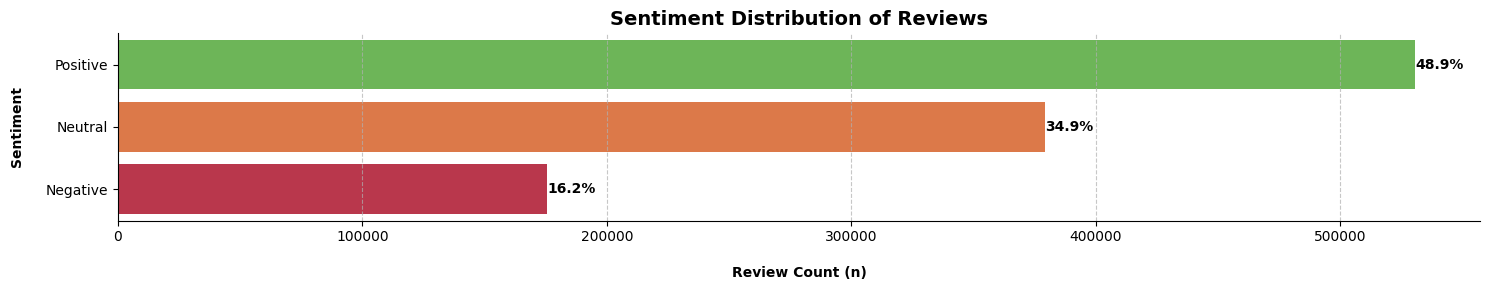

In [27]:
# ============================================
#      Analysis of Sentiment Results
# ============================================
# Count the number of reviews for each sentiment
TXRBSF_sentiment_pd = TXRBSF_sentiment_df.groupBy("SentimentLabel") \
    .count() \
    .orderBy(F.desc("count")) \
    .toPandas() # Convert to Pandas for visualization

# Ensure the order matches the color dict if needed for consistency
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.set_index('SentimentLabel').reindex(sentiment_colors.keys()).reset_index().fillna(0)

# Plot the sentiment counts
plt.figure(figsize=(15, 3))
sns.barplot(x="count", y="SentimentLabel", data=TXRBSF_sentiment_pd,
            palette=sentiment_colors, order=sentiment_colors.keys())

plt.title("Sentiment Distribution of Reviews", fontsize=14, fontweight='bold')
plt.xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Sentiment\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(TXRBSF_sentiment_pd['count']):
    percentage = (value / TXRBSF_sentiment_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

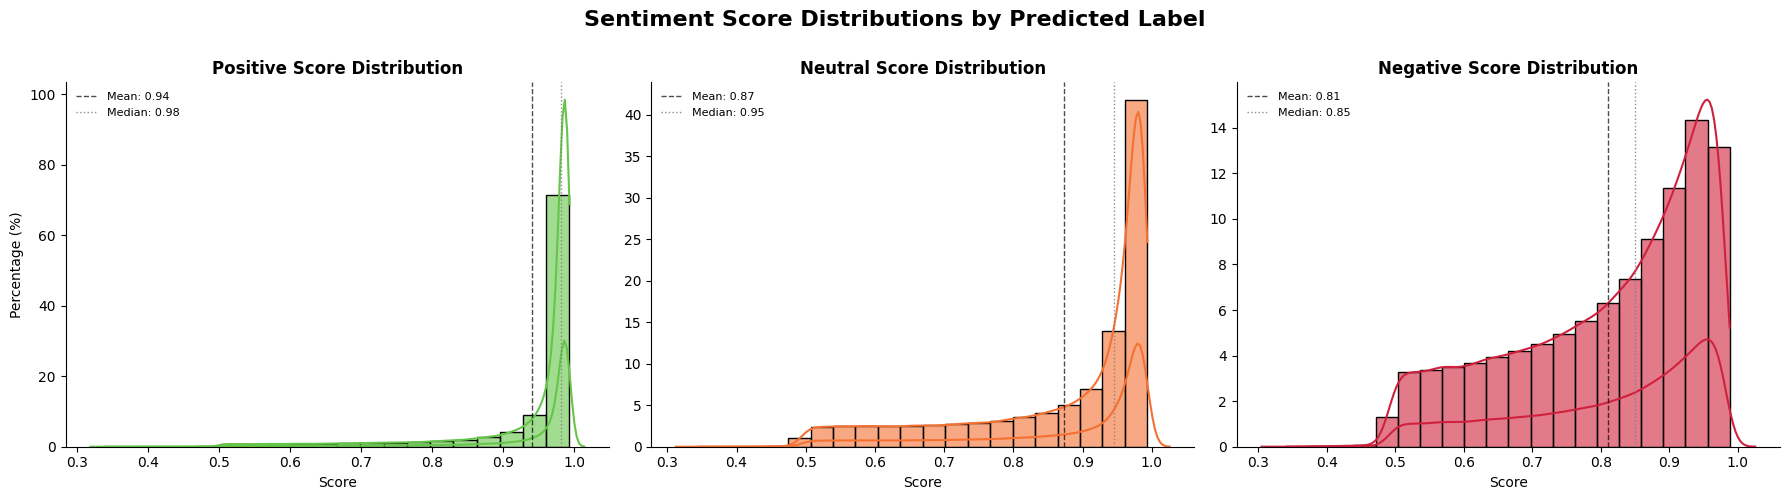

In [28]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_sentiments = len(sentiment_colors)
n_cols = 3
n_rows = ceil(n_sentiments / n_cols)

fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
TXRBSF_sentiment_pd = TXRBSF_sentiment_df.select("SentimentLabel", "SentimentScore").toPandas()     # Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for sentiment, color in sentiment_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = TXRBSF_sentiment_pd[TXRBSF_sentiment_pd["SentimentLabel"] == sentiment]["SentimentScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{sentiment} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{sentiment} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Sentiment Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)    # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

---

## 🟡 **HuggingFace [mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7)**

In [29]:
# Sentiment Analysis | mDeBERTa-v3
# Source: https://huggingface.co/docs/transformers/main_classes/pipelines
#         https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7
model_path = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
moritz_classifier = pipeline("zero-shot-classification", model=model_path, tokenizer=model_path, device=device)

mDeBERTa_zero_shot_classifier = pipeline("zero-shot-classification",                           # Task Name (List Source: https://huggingface.co/tasks)
    model=model_path, tokenizer=model_path,                                         # mDeBERTa
    max_length=512,                                                                 # Maximum Length of the Input Sequence
    truncation=True,                                                                # Truncate the Input Sequence
    device=device                                                                   # Use the automatically detected device
)

# Define sentiment labels for zero-shot classification
sentiment_labels = ["Positive", "Neutral", "Negative"]  # Candidate labels for sentiment

# Function to classify sentiment (Simple Function)
def mDeBERTa_classify_sentiment(text):
    # Classify the sentiment
    outputs = mDeBERTa_zero_shot_classifier([text], sentiment_labels, multi_label=False, batch_size=8)

    # Extract the label and score from the output with more probability
    labels = [output['labels'][0] for output in outputs]
    scores = [output['scores'][0] for output in outputs]

    return labels[0], scores[0]


# Example usage (Pipeline & Function)
examples_text = ["This product is amazing! I love it.", "I didn't like this product at all.", "It's okay, not the best but not the worst."]

for text in examples_text:
    print(f"Text: {text}")
    print(f"Pipeline Output: {mDeBERTa_zero_shot_classifier(text, sentiment_labels, multi_label=False)}")
    print(f"Function Output: {mDeBERTa_classify_sentiment(text)}")
    print("\n")

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0
Device set to use cuda:0


Text: This product is amazing! I love it.
Pipeline Output: {'sequence': 'This product is amazing! I love it.', 'labels': ['Positive', 'Neutral', 'Negative'], 'scores': [0.9837570786476135, 0.013960531912744045, 0.0022824015468358994]}
Function Output: ('Positive', 0.9837570190429688)


Text: I didn't like this product at all.
Pipeline Output: {'sequence': "I didn't like this product at all.", 'labels': ['Negative', 'Neutral', 'Positive'], 'scores': [0.9229488372802734, 0.07602698355913162, 0.0010241138515993953]}
Function Output: ('Negative', 0.9229491353034973)


Text: It's okay, not the best but not the worst.
Pipeline Output: {'sequence': "It's okay, not the best but not the worst.", 'labels': ['Positive', 'Neutral', 'Negative'], 'scores': [0.5803689956665039, 0.28823143243789673, 0.13139958679676056]}
Function Output: ('Positive', 0.5803704857826233)




In [ ]:
# ============================================ APPLY mDeBERTa_sentiment_classifier ============================================
# Apply the sentiment classification function to the reviews DataFrame

# 1st Step: Load Hugging Face Pipeline | Sentiment Analysis (Zero-Shot Classification)
# Already done above (mDeBERTa_zero_shot_classifier)

# 2nd Step: Define Output Path on Google Drive
gdrive_output_dir = "/content/drive/MyDrive/AmazonReviews_Results"
sentiment_output_file = os.path.join(gdrive_output_dir, "ReviewsSentiment_mDeBERTa.tsv")

# # If we wanna run in Databricks: Using DBFS
# dbfs_output_dir = "dbfs:/FileStore/AmazonReviews_Results"
# sentiment_output_file_dbfs = os.path.join(dbfs_output_dir, "ReviewsSentiment_mDeBERTa.tsv")
# sentiment_output_file = sentiment_output_file_dbfs

# 3rd Step: Run the Classification Function | Sentiment Analysis
# Apply zero-shot sentiment classification to reviews
sentiment_path, sentiment_count, sentiment_time = classify_text_spark_incremental(
    spark=spark,                                     # Use the active Spark session
    input_df=reviews_df,                             # Input DataFrame with review data
    pipeline_instance=mDeBERTa_zero_shot_classifier, # Zero-shot classification pipeline
    id_col="review_id",                              # Column for unique review IDs
    text_col="review_text",                          # Column with review text
    output_path=sentiment_output_file,               # Path to save sentiment results
    output_label_col="SentimentLabel",               # Name of the output column for labels
    output_score_col="SentimentScore",               # Name of the output column for scores
    candidate_labels=sentiment_labels,               # Use sentiment labels for zero-shot
    batch_size=32,                                   # Process 32 reviews per batch
    save_interval=1000                               # Save results every 1000 rows
)


# Verify Output
results_sentiment_spark = spark.read.csv(sentiment_path, sep='\t', header=True, inferSchema=True)
print(f"Sentiment results count: {results_sentiment_spark.count()}")
display(results_sentiment_spark.show(5))                    # For Databricks


# --------------------------------------------------------- 1st Time Running
# Google Colab environment set up
# No existing results found
# Processing 1085883 new rows
# Classifying Text:  31%|███       | 331595/1085883 [4:15:49<8:07:47, 25.77row/s]

Google Colab environment set up
Loaded 504000 processed IDs
Processing 581883 new rows


Classifying Text: 100%|██████████| 581883/581883 [4:35:33<00:00, 35.20row/s]

Saved final 407 rows, total processed: 581431
Processed 581431 rows in 17102.26 seconds


Sentiment results count: 1085431
+--------------+------------------+---------+--------------------+
|SentimentLabel|    SentimentScore|review_id|         review_text|
+--------------+------------------+---------+--------------------+
|      Positive|0.9945146441459656|   871006|Excellent Product...|
|      Positive|0.9787976741790771|   215673|Beautiful I reall...|
|      Positive|0.9949206709861755|  1021746|great PC this is ...|
|      Positive|0.6813863515853882|   835069|Tough and sturdy ...|
|      Positive|0.8912148475646973|   128608|It work Perfect t...|
+--------------+------------------+---------+--------------------+
only showing top 5 rows



None

In [31]:
# Read the saved CSV file to verify
# output_csv_path = "./AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv"                                        # Local Path
output_csv_path = "/content/drive/MyDrive/AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv"                 # Google Colab Path
# output_csv_path = "dbfs:/FileStore/AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv"                        # Databricks Path

# Read the saved TSV file with explicit schema
mDeBERTa_sentiment_df = spark.read.csv(output_csv_path, sep='\t', header=True, inferSchema=True)

# Show the first few rows of the sentiment classification results
print("\n\033[1mSentiment Classification Results:\033[0m")
# display(mDeBERTa_sentiment_df.limit(5))
mDeBERTa_sentiment_df.show(5, truncate=False)


Sentiment Classification Results:
+--------------+------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SentimentLabel|SentimentScore    |review_id|review_text                                                                                                                                                                            |
+--------------+------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Positive      |0.9945146441459656|871006   |Excellent Product Super fast delivery Product is exactly as described and of great quality Very satisfied with this entire transaction I highly recommend this item and this seller 100|
|Positive      |0.9787976741790771|215673   |

In [32]:
# Count the number of reviews for each sentiment
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_df.groupBy("SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Sentiment Counts
mDeBERTa_sentiment_pd['%'] = mDeBERTa_sentiment_pd['count'] / mDeBERTa_sentiment_pd['count'].sum()            # Calculate relative counts
mDeBERTa_sentiment_pd['%'] = mDeBERTa_sentiment_pd['%'].apply(lambda x: f"{x:.2%}")                           # Format as percentage
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.rename(columns={"SentimentLabel": "Sentiment", "count": "n"})   # Rename columns
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd[["Sentiment", "n", "%"]]                                        # Reorder columns
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.set_index("Sentiment")                                          # Set 'Sentiment' as index
mDeBERTa_sentiment_pd

,n,%
Sentiment,,
Positive,799639,73.67%
Negative,279410,25.74%
Neutral,6382,0.59%


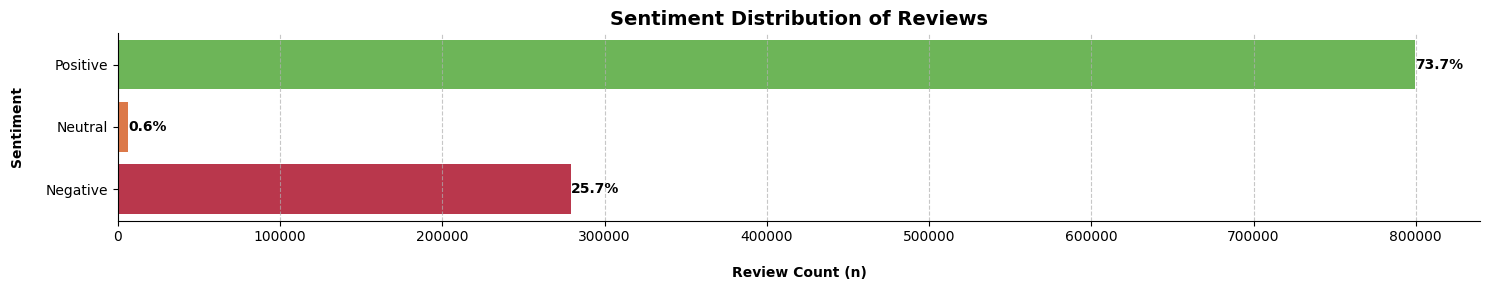

In [33]:
# ============================================
#      Analysis of Sentiment Results
# ============================================
# Count the number of reviews for each sentiment
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_df.groupBy("SentimentLabel") \
    .count() \
    .orderBy(F.desc("count")) \
    .toPandas() # Convert to Pandas for visualization

# Ensure the order matches the color dict if needed for consistency
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.set_index('SentimentLabel').reindex(sentiment_colors.keys()).reset_index().fillna(0)

# Plot the sentiment counts
plt.figure(figsize=(15, 3))
sns.barplot(x="count", y="SentimentLabel", data=mDeBERTa_sentiment_pd,
            palette=sentiment_colors, order=sentiment_colors.keys())

plt.title("Sentiment Distribution of Reviews", fontsize=14, fontweight='bold')
plt.xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Sentiment\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(mDeBERTa_sentiment_pd['count']):
    percentage = (value / mDeBERTa_sentiment_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

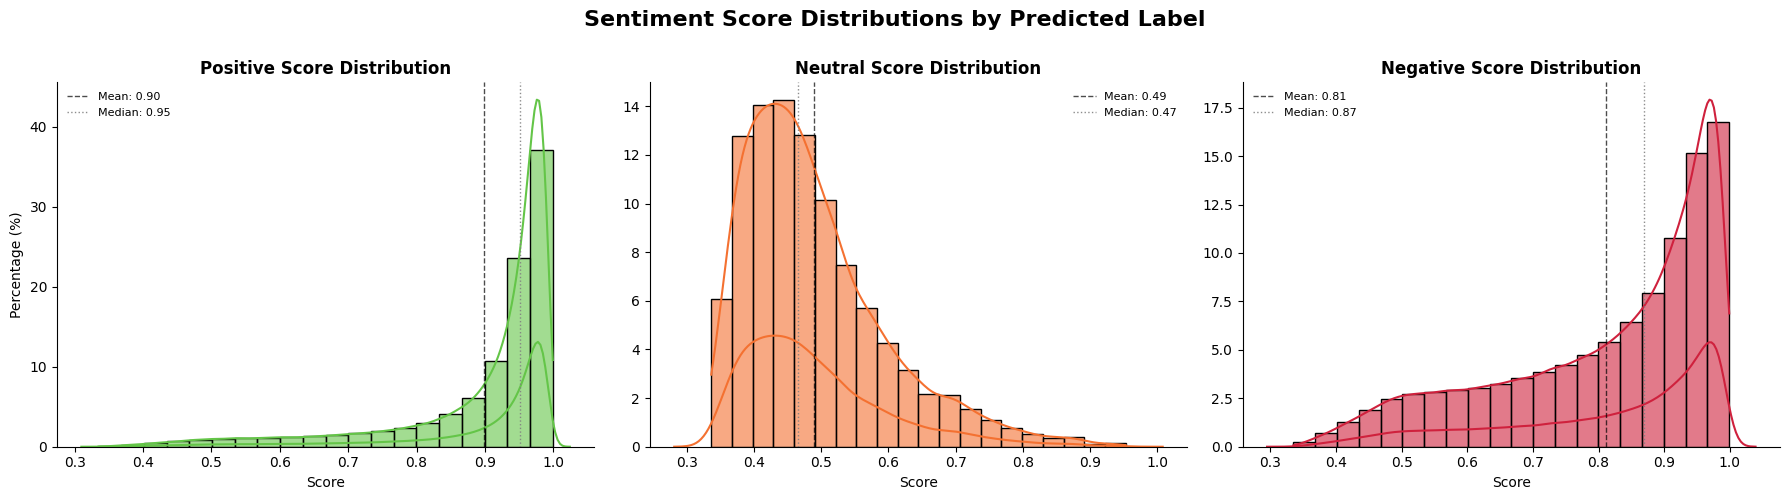

In [ ]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_sentiments = len(sentiment_colors)
n_cols = 3
n_rows = ceil(n_sentiments / n_cols)

fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_df.select("SentimentLabel", "SentimentScore").toPandas() # Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for sentiment, color in sentiment_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = mDeBERTa_sentiment_pd[mDeBERTa_sentiment_pd["SentimentLabel"] == sentiment]["SentimentScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{sentiment} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{sentiment} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Sentiment Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)    # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

In [35]:
# ============================================
#      Sentiment Models Confusion Matrix
# ============================================
# Define sentiment labels for ordering the confusion matrix
sentiment_labels = ["Positive", "Neutral", "Negative"]  # List of possible sentiment labels

# Join TXRBSF and mDeBERTa DataFrames on review_id
joined_df = TXRBSF_sentiment_df.select("review_id", F.col("SentimentLabel").alias("TXRBSF_SentimentLabel")  # Rename for clarity
                                       ).join(
                                           mDeBERTa_sentiment_df.select("review_id",F.col("SentimentLabel").alias("mDeBERTa_SentimentLabel")),
                                           on="review_id",      # Join on review_id
                                           how="inner")         # Keep only matching reviews

# Filter out rows with null sentiment labels
clean_df = joined_df.filter(
    F.col("TXRBSF_SentimentLabel").isNotNull() &
    F.col("mDeBERTa_SentimentLabel").isNotNull()
)  # Remove rows with null labels

# Create the confusion matrix using groupBy and pivot
conf_matrix_df = clean_df.groupBy("TXRBSF_SentimentLabel").pivot(
    "mDeBERTa_SentimentLabel",
    sentiment_labels
).count().fillna(0)  # Count occurrences and fill missing values with 0

# Order rows by sentiment_labels
# Create a temporary ordering column based on the desired sentiment_labels sequence
conf_matrix_df = conf_matrix_df.withColumn(
    "sort_order",
    F.when(F.col("TXRBSF_SentimentLabel") == "Positive", 0)
     .when(F.col("TXRBSF_SentimentLabel") == "Neutral", 1)
     .when(F.col("TXRBSF_SentimentLabel") == "Negative", 2)
     .otherwise(99) # Assign a high number for any unexpected labels
)

# Order the DataFrame by the temporary sort_order column
conf_matrix_df = conf_matrix_df.orderBy("sort_order")

# Drop the temporary ordering column
conf_matrix_df = conf_matrix_df.drop("sort_order")

# Display the confusion matrix
print("\n\033[1mConfusion Matrix (TXRBSF vs mDeBERTa Sentiment):\033[0m")
print("Rows: TXRBSF_SentimentLabel, Columns: mDeBERTa_SentimentLabel")
conf_matrix_pd = conf_matrix_df.toPandas()                                  # Convert to Pandas DataFrame for visualization
conf_matrix_pd = conf_matrix_pd.set_index("TXRBSF_SentimentLabel")          # Set TXRBSF labels as index
conf_matrix_pd.index.name = "TXRBSF Model"                                  # Rename index to 'TXRBSF Model'
conf_matrix_pd.columns.name = "mDeBERTa Model"                              # Rename columns index to 'mDeBERTa Model'
conf_matrix_pd


Confusion Matrix (TXRBSF vs mDeBERTa Sentiment):
Rows: TXRBSF_SentimentLabel, Columns: mDeBERTa_SentimentLabel


mDeBERTa Model,Positive,Neutral,Negative
TXRBSF Model,,,
Positive,525061,341,5165
Neutral,257855,5453,115891
Negative,16723,588,158354


In [ ]:
# ============================================
#      Combine Sentiment Models into Single Label
# ============================================

# Join TXRBSF and mDeBERTa DataFrames on review_id
joined_df = TXRBSF_sentiment_df.select("review_id",
                                       F.col("SentimentLabel").alias("TXRBSF_SentimentLabel"),            # Rename for clarity
                                       "review_text"                                                      # Include review_text for context
).join(
    mDeBERTa_sentiment_df.select("review_id", F.col("SentimentLabel").alias("mDeBERTa_SentimentLabel")),  # Rename for clarity
    on="review_id",                                                                                       # Join on review_id
    how="inner"                                                                                           # Keep only matching reviews
)

# Define conditions and values for Combined_Sentiment
combined_df = joined_df.withColumn(
    "Combined_Sentiment",
    when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Positive"  # Both Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Positive Tendency"  # Positive + Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Neutral"  # Positive + Negative
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Positive Tendency"  # Neutral + Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Neutral"  # Both Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Negative Tendency"  # Neutral + Negative
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Neutral"  # Negative + Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Negative Tendency"  # Negative + Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Negative"  # Both Negative
    ).otherwise(
        None  # Set to null if any label is null or conditions don’t match
    )
)

# Ensure Combined_Sentiment is null where either input label is null
combined_df = combined_df.withColumn(
    "Combined_Sentiment",
    when(
        (col("TXRBSF_SentimentLabel").isNull()) |
        (col("mDeBERTa_SentimentLabel").isNull()),
        None  # Set to null if either label is missing
    ).otherwise(col("Combined_Sentiment"))
)

# Count the occurrences of each Combined_Sentiment value
sentiment_counts = combined_df.groupBy("Combined_Sentiment").count().orderBy(F.desc("count"))  # Group and count

# Display the value counts
print("\n\033[1mCombined Sentiment Value Counts:\033[0m")
sentiment_counts_pd = sentiment_counts.toPandas()                                              # Convert to Pandas DataFrame for visualization
sentiment_counts_pd = sentiment_counts_pd.set_index("Combined_Sentiment")                      # Set Combined_Sentiment as index
sentiment_counts_pd.index.name = "Combined Sentiment"                                          # Rename index to 'Combined Sentiment'
sentiment_counts_pd.rename(columns={"count": "n"}, inplace=True)                               # Rename count column to 'n'
sentiment_counts_pd['%'] = sentiment_counts_pd['n'] / sentiment_counts_pd['n'].sum()           # Calculate relative counts
sentiment_counts_pd['%'] = sentiment_counts_pd['%'].apply(lambda x: f"{x:.2}")                 # Round to 2 decimal places
sentiment_counts_pd


Combined Sentiment Value Counts:


,n,%
Combined Sentiment,,
Positive,525061,0.48
Positive Tendency,258196,0.24
Negative,158354,0.15
Negative Tendency,116479,0.11
Neutral,27341,0.025


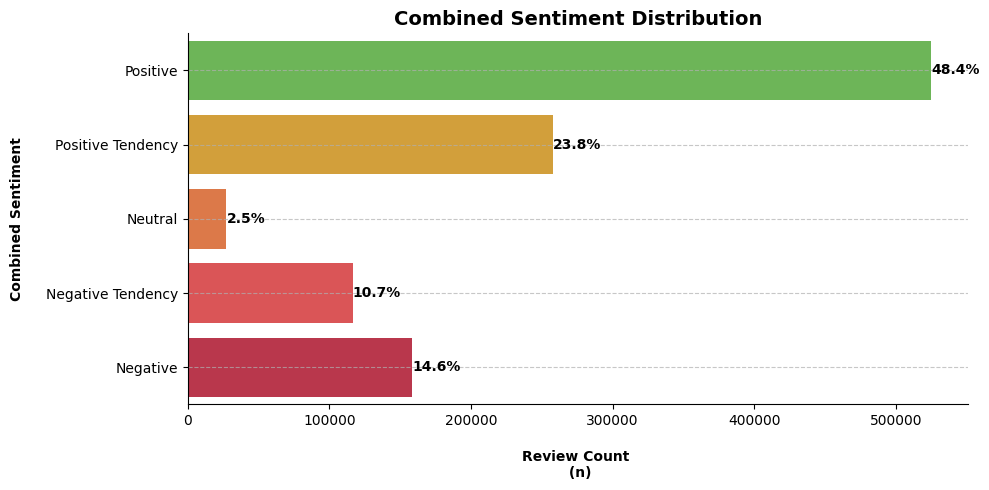

In [37]:
# Bar Plot of Combined Sentiment Counts
plt.figure(figsize=(10, 5))
sns.barplot(x="n", y="Combined Sentiment", data=sentiment_counts_pd.reset_index(),
            palette=sentiment_colors_full, order=sentiment_colors_full.keys())
plt.title("Combined Sentiment Distribution", fontsize=14, fontweight='bold')
plt.xlabel("\nReview Count \n (n)", fontsize=10, fontweight='bold')
plt.ylabel("Combined Sentiment\n", fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages on the bars
total = sentiment_counts_pd['n'].sum()
for index, row in sentiment_counts_pd.iterrows():
    percentage = (row['n'] / total) * 100
    plt.text(row['n'] + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

---

# <span style="color: #ffffff;">Topic Analysis</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #3D1C87;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #3D1C87;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Topic Analysis</b></h2></center>
</div>
<br>

In [38]:
# mDeBERTa-v3-base-xnli-multilingual-nli-2mil7 Zero-Shot Classification Model for Topics

# Topic Analysis (Zero-Shot Classification)
mDeBERTa_topic_classifier = pipeline("zero-shot-classification",                    # Task Name (List Source: https://huggingface.co/tasks)
    model=model_path, tokenizer=model_path,                                         # mDeBERTa
    max_length=512,                                                                 # Maximum Length of the Input Sequence
    truncation=True,                                                                # Truncate the Input Sequence
    device=device                                                                   # Use the automatically detected device
)

# Define candidate labels for product topics based on Amazon categories
topic_candidate_labels = [
    "Laptops", "Desktops", "PC Gaming", "Monitors", "Tablets",
    "Computer Components", "Computer Accessories", "Networking",
    "Drives and Storage", "Printers and Ink", "Software", "Others" # General category
]

# Function to classify topics (Simple Function)
def mDeBERTa_classify_topic(text):
    # Classify the topic
    outputs = mDeBERTa_topic_classifier([text], topic_candidate_labels, multi_label=False, batch_size=8)

    # Extract the label and score from the output with more probability
    labels = [output['labels'][0] for output in outputs]
    scores = [output['scores'][0] for output in outputs]

    return labels[0], scores[0]

# Example usage (Pipeline & Function)
examples_text = [
    "This laptop is great for gaming and productivity.",
    "The new desktop computer has a powerful graphics card.",
    "I love my new tablet for reading and browsing the web.",
    "The monitor has excellent color accuracy and resolution.",
    "This printer is perfect for home office use."
]

for text in examples_text:
    print(f"Text: {text}")
    print(f"Pipeline Output: {mDeBERTa_topic_classifier(text, topic_candidate_labels, multi_label=False)}")
    print(f"Function Output: {mDeBERTa_classify_topic(text)}")
    print("\n")

Device set to use cuda:0


Text: This laptop is great for gaming and productivity.
Pipeline Output: {'sequence': 'This laptop is great for gaming and productivity.', 'labels': ['Laptops', 'Computer Accessories', 'Computer Components', 'PC Gaming', 'Monitors', 'Others', 'Software', 'Desktops', 'Drives and Storage', 'Networking', 'Tablets', 'Printers and Ink'], 'scores': [0.8297678232192993, 0.05153762921690941, 0.0362112931907177, 0.03048497438430786, 0.01749102957546711, 0.012647615745663643, 0.007358761504292488, 0.005120738409459591, 0.004604867193847895, 0.0030435698572546244, 0.0013126698322594166, 0.00041911174776032567]}
Function Output: ('Laptops', 0.8297669291496277)


Text: The new desktop computer has a powerful graphics card.
Pipeline Output: {'sequence': 'The new desktop computer has a powerful graphics card.', 'labels': ['Desktops', 'Computer Components', 'Others', 'Monitors', 'Software', 'Computer Accessories', 'Drives and Storage', 'Laptops', 'PC Gaming', 'Networking', 'Tablets', 'Printers and Ink

In [39]:
# ============================================ APPLY mDeBERTa_topic_classifier ============================================
# Apply the topic classification function to the products DataFrame
# 1st Step: Load Hugging Face Pipeline | Topic Analysis (Zero-Shot Classification)
# Already done above (mDeBERTa_topic_classifier)

# 2nd Step: Define Output Path on Google Drive
gdrive_output_dir = "/content/drive/MyDrive/AmazonReviews_Results"
topic_output_file = os.path.join(gdrive_output_dir, "ProductTitleTopic_mDeBERTa.tsv")

# # If we wanna run in Databricks: Using DBFS
# dbfs_output_dir = "dbfs:/FileStore/AmazonReviews_Results"
# topic_output_file_dbfs = os.path.join(dbfs_output_dir, "ProductTitleTopic_mDeBERTa.tsv")
# topic_output_file = topic_output_file_dbfs
# dbutils.fs.rm(dbfs_output_dir, recurse=False)

# 3rd Step: Run the Classification Function | Topic Analysis
# Apply zero-shot topic classification to products
topic_path, topic_count, topic_time = classify_text_spark_incremental(
    spark=spark,                                     # Use the active Spark session
    input_df=products_df,                            # Input DataFrame with product data
    pipeline_instance=mDeBERTa_topic_classifier,     # Zero-shot classification pipeline
    id_col="parent_asin",                            # Column for unique product IDs
    text_col="meta_title",                           # Column with product titles
    output_path=topic_output_file,                   # Path to save topic results
    output_label_col="TopicLabel",                   # Name of the output column for labels
    output_score_col="TopicScore",                   # Name of the output column for scores
    candidate_labels=topic_candidate_labels,         # Use topic labels for zero-shot
    batch_size=32,                                   # Process 32 products per batch
    save_interval=1000                               # Save results every 1000 rows
)

# Verify Output
results_topic_spark = spark.read.csv(topic_path, sep='\t', header=True, inferSchema=True)
print(f"Topic results count: {results_topic_spark.count()}")
display(results_topic_spark.show(5))                    # For Databricks

Google Colab environment set up
No existing results found
Processing 59418 new rows


Classifying Text: 100%|██████████| 59418/59418 [28:00<00:00, 35.36row/s]

Saved final 410 rows, total processed: 59418
Processed 59418 rows in 1680.57 seconds


Topic results count: 59418
+--------------------+-------------------+--------------------+-----------+
|          TopicLabel|         TopicScore|          meta_title|parent_asin|
+--------------------+-------------------+--------------------+-----------+
|Computer Accessories|0.39941948652267456|YINOVEEN 14 inch ...| B09NPRKGTB|
|Computer Accessories| 0.4596309959888458|45W 65W Computer ...| B09NPTT6ZV|
|             Laptops|  0.415480375289917|HP 2021 14 FullHD...| B09NPVRDPW|
|             Laptops| 0.5114923715591431|Replacement Dell ...| B09NPWHM6S|
|            Monitors| 0.9450803399085999|AOPEN Portable Mo...| B09NPWSJYL|
+--------------------+-------------------+--------------------+-----------+
only showing top 5 rows



None

In [40]:
# Read the saved CSV file to verify
# output_csv_path = "./AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv"                                    # Local Path
output_csv_path = "/content/drive/MyDrive/AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv"               # Google Colab Path
# output_csv_path = "dbfs:/FileStore/AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv"                      # Databricks Path

# Read the saved TSV file with explicit schema
mDeBERTa_topic_df = spark.read.csv(output_csv_path, sep='\t', header=True, inferSchema=True)

# Show the first few rows of the topic classification results
print("\n\033[1mTopic Classification Results:\033[0m")
display(mDeBERTa_topic_df.limit(5))                                                              # For Databricks

# Count the number of products for each topic
mDeBERTa_topic_pd = mDeBERTa_topic_df.groupBy("TopicLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Topic Counts
mDeBERTa_topic_pd['%'] = mDeBERTa_topic_pd['count'] / mDeBERTa_topic_pd['count'].sum()            # Calculate relative counts
mDeBERTa_topic_pd['%'] = mDeBERTa_topic_pd['%'].apply(lambda x: f"{x:.2}")                        # Round to 2 decimal places
mDeBERTa_topic_pd = mDeBERTa_topic_pd.rename(columns={"TopicLabel": "Topic", "count": "n"})       # Rename columns
mDeBERTa_topic_pd = mDeBERTa_topic_pd[["Topic", "n", "%"]]                                        # Reorder columns
mDeBERTa_topic_pd = mDeBERTa_topic_pd.set_index("Topic")                                          # Set 'Topic' as index
mDeBERTa_topic_pd


Topic Classification Results:


DataFrame[TopicLabel: string, TopicScore: double, meta_title: string, parent_asin: string]

,n,%
Topic,,
Drives and Storage,12978,0.22
Laptops,11905,0.2
Computer Components,8961,0.15
Tablets,7909,0.13
Computer Accessories,7368,0.12
Monitors,3075,0.052
Networking,2990,0.05
Software,1760,0.03
Desktops,1259,0.021


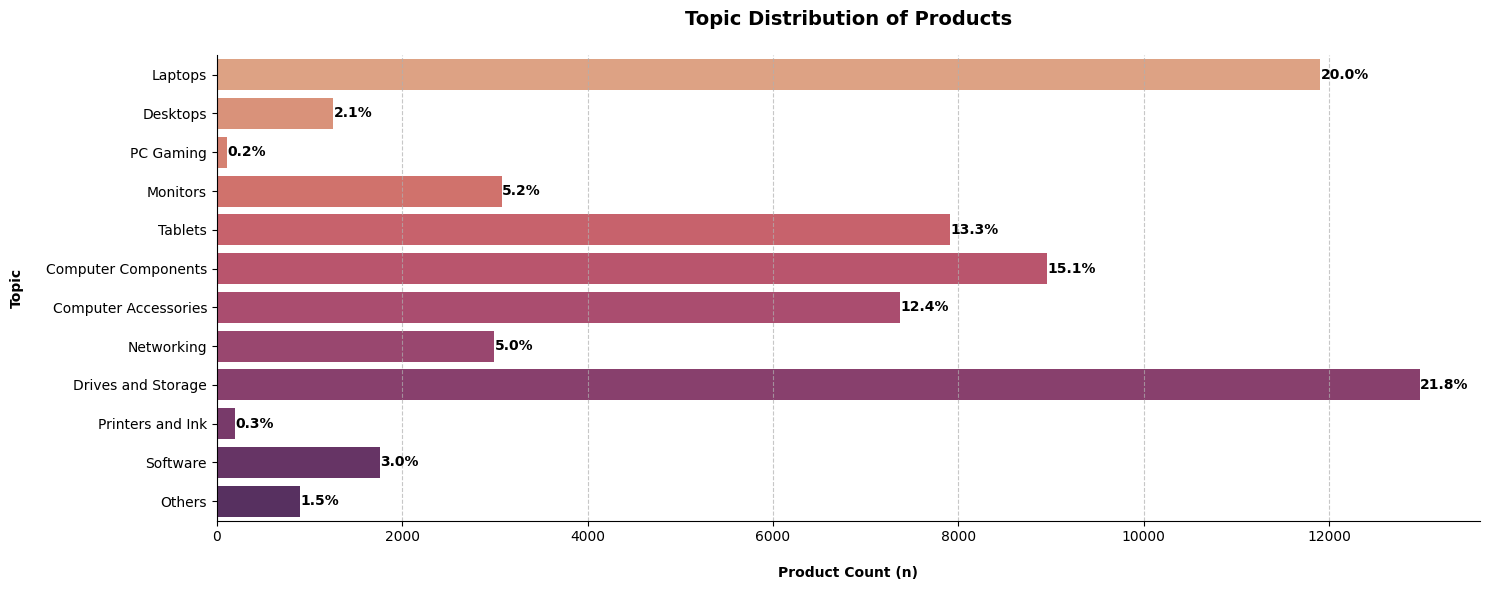

In [41]:
# ============================================
#      Analysis of Topic Results
# ============================================
# Count the number of products for each topic
mDeBERTa_topic_pd = mDeBERTa_topic_df.groupBy("TopicLabel") \
    .count() \
    .orderBy(F.desc("count")) \
    .toPandas() # Convert to Pandas for visualization

# Ensure the order matches the color dict if needed for consistency
mDeBERTa_topic_pd = mDeBERTa_topic_pd.set_index('TopicLabel').reindex(topic_candidate_labels).reset_index().fillna(0)

# Create a color dictionary using the 'flare' palette
colors = sns.color_palette("flare", n_colors=len(topic_candidate_labels))  # Generate 12 colors from 'flare' palette
topic_colors = dict(zip(topic_candidate_labels, colors))                   # Map each topic to a color

# Plot the topic counts
plt.figure(figsize=(15, 6))
sns.barplot(x="count", y="TopicLabel", data=mDeBERTa_topic_pd,
            palette=topic_colors, order=topic_candidate_labels)
plt.title("Topic Distribution of Products\n", fontsize=14, fontweight='bold')
plt.xlabel("\nProduct Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Topic\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(mDeBERTa_topic_pd['count']):
    percentage = (value / mDeBERTa_topic_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

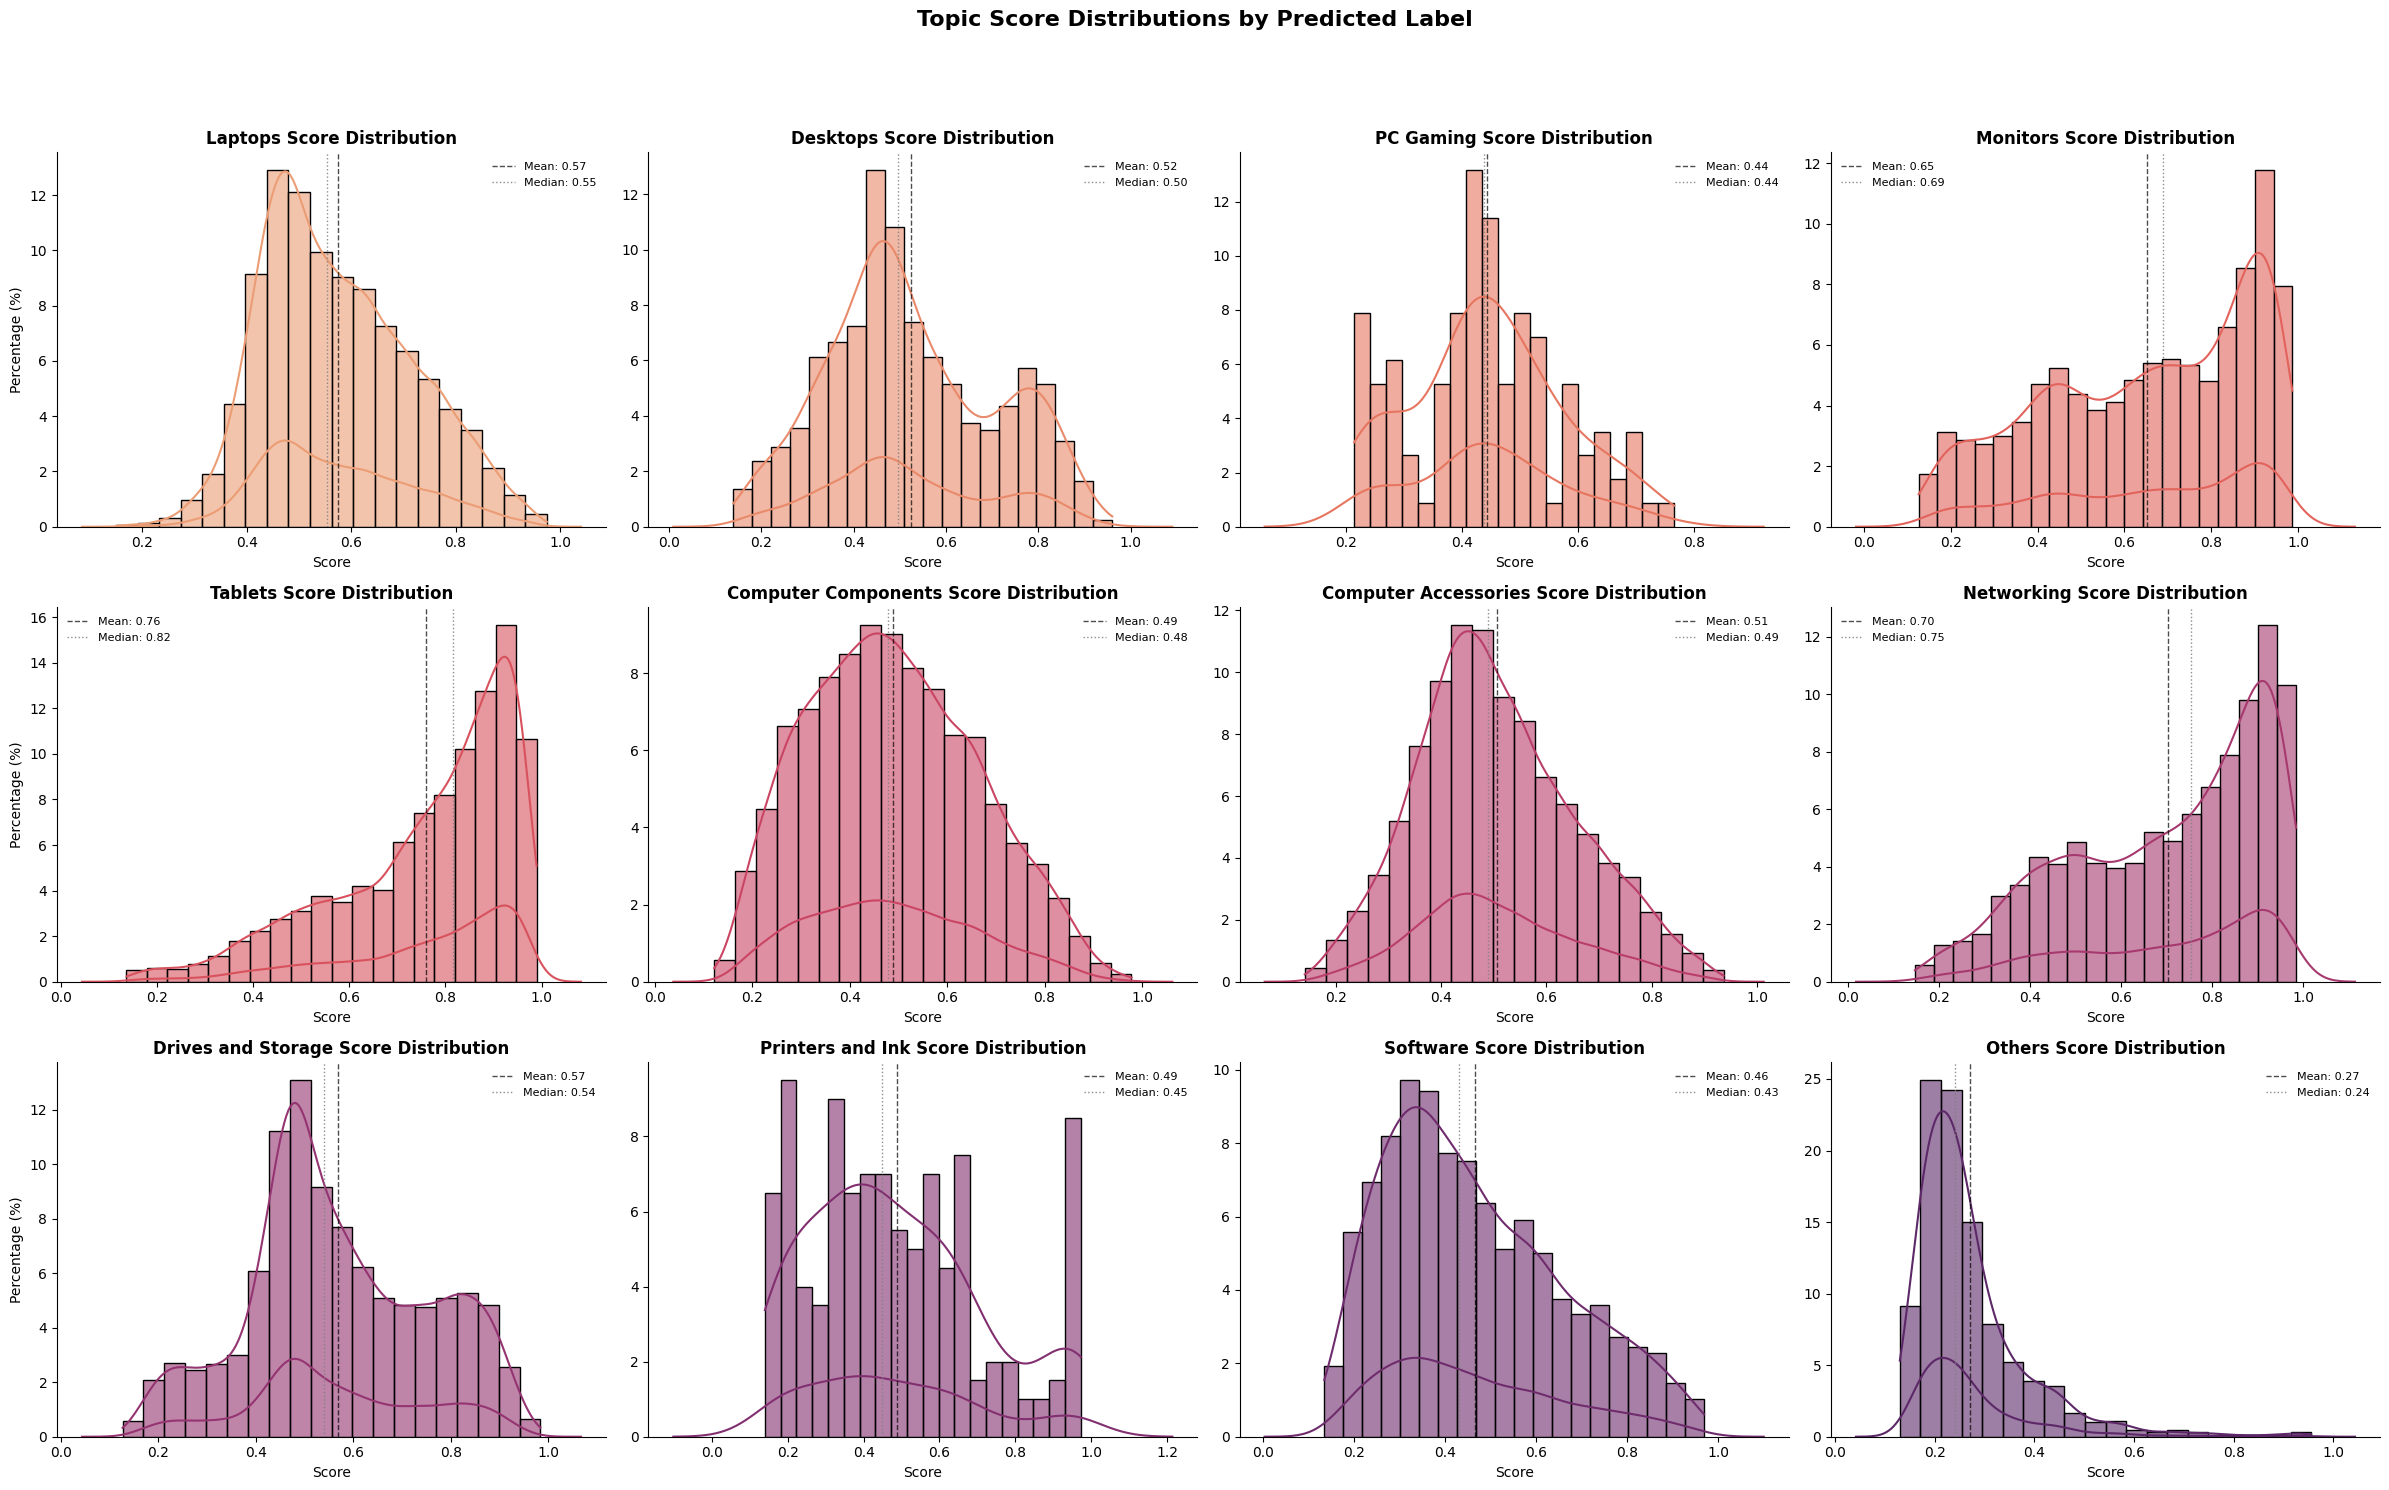

In [42]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_topics = len(topic_candidate_labels)
n_cols = 4
n_rows = ceil(n_topics / n_cols)
fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
mDeBERTa_topic_pd = mDeBERTa_topic_df.select("TopicLabel", "TopicScore").toPandas()                 # Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for topic, color in topic_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = mDeBERTa_topic_pd[mDeBERTa_topic_pd["TopicLabel"] == topic]["TopicScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{topic} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{topic} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Topic Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)        # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

---

# **💾 Save Data**

In [43]:
# Extra: Save results datasets as .zip in Google Drive
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')

# Compress the TSV directories into a ZIP file
# ReviewsSentiment_TXRBSF.tsv
shutil.make_archive("/content/drive/My Drive/AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv", "zip", "/content/drive/My Drive/AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv")

# ReviewsSentiment_mDeBERTa.tsv
shutil.make_archive("/content/drive/My Drive/AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv", "zip", "/content/drive/My Drive/AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv")

# ProductTitleTopic_mDeBERTa.tsv
shutil.make_archive("/content/drive/My Drive/AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv", "zip", "/content/drive/My Drive/AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv")

# Verify the ZIP file exists
print("\nSaved files in /content/drive/My Drive/AmazonReviews_Results:")
for file in os.listdir("/content/drive/My Drive/AmazonReviews_Results"):
    # Check if the file is a ZIP file
    if file.endswith(".zip"):
        print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Saved files in /content/drive/My Drive/AmazonReviews_Results:
ReviewsSentiment_TXRBSF.tsv.zip
ReviewsSentiment_mDeBERTa.tsv.zip
ProductTitleTopic_mDeBERTa.tsv.zip


In [ ]:
# ============================================
#      Combine and Save All Essential Columns
# ============================================
import os
import shutil
import zipfile

# Define directories
local_output_dir = "/content/AmazonReviews_Results"                 # Local storage for Parquet files
gdrive_output_dir = "/content/drive/MyDrive/AmazonReviews_Results"  # Google Drive for zip files

# Ensure the local output directory exists
if not os.path.exists(local_output_dir):
    os.makedirs(local_output_dir)

# Ensure the Google Drive output directory exists
if not os.path.exists(gdrive_output_dir):
    os.makedirs(gdrive_output_dir)

# Define output paths for Parquet files (local) and zip files (Google Drive)
reviews_parquet_path = os.path.join(local_output_dir, "reviews_df")
products_parquet_path = os.path.join(local_output_dir, "products_df")
reviews_zip_path = os.path.join(gdrive_output_dir, "df-computers-reviews-results.zip")
products_zip_path = os.path.join(gdrive_output_dir, "df-computers-products-results.zip")

# Reload the DataFrames from the TSV files
ReviewsSentiment_TXRBSF = spark.read.csv("/content/drive/MyDrive/AmazonReviews_Results/ReviewsSentiment_TXRBSF.tsv", sep='\t', header=True, inferSchema=True)
ReviewsSentiment_mDeBERTa = spark.read.csv("/content/drive/MyDrive/AmazonReviews_Results/ReviewsSentiment_mDeBERTa.tsv", sep='\t', header=True, inferSchema=True)
ProductTitleTopic_mDeBERTa = spark.read.csv("/content/drive/MyDrive/AmazonReviews_Results/ProductTitleTopic_mDeBERTa.tsv", sep='\t', header=True, inferSchema=True)


# Step 1: Enhance reviews_df with sentiment data
# Join reviews_df with ReviewsSentiment_TXRBSF and ReviewsSentiment_mDeBERTa
reviews_df = reviews_df.join(
    ReviewsSentiment_TXRBSF.select(
        "review_id",
        F.col("SentimentLabel").alias("TXRBSF_SentimentLabel"),
        F.col("SentimentScore").alias("TXRBSF_SentimentScore")
    ),
    on="review_id",
    how="left"  # Keep all reviews, even if sentiment is missing
).join(
    ReviewsSentiment_mDeBERTa.select(
        "review_id",
        F.col("SentimentLabel").alias("mDeBERTa_SentimentLabel"),
        F.col("SentimentScore").alias("mDeBERTa_SentimentScore")
    ),
    on="review_id",
    how="left"  # Keep all reviews, even if sentiment is missing
)

# Select relevant columns for reviews_df
reviews_df = reviews_df.select("review_id", "review_text", "parent_asin", "user_id", "rating",
                               "helpful_vote", "timestamp", "timestamp_dt", "year", "month", "day",
                               "day_of_week", "hour", "TXRBSF_SentimentLabel", "TXRBSF_SentimentScore",
                               "mDeBERTa_SentimentLabel","mDeBERTa_SentimentScore")

# Step 2: Enhance products_df with topic data
# Join products_df with ProductTitleTopic_mDeBERTa
products_df = products_df.join(
    ProductTitleTopic_mDeBERTa.select(
        "parent_asin",
        F.col("TopicLabel").alias("TopicLabel"),
        F.col("TopicScore").alias("TopicScore")
    ),
    on="parent_asin",
    how="left"  # Keep all products, even if topic data is missing
)

# Select relevant columns for products_df
products_df = products_df.select("parent_asin", F.col("meta_title").alias("product_title"),
                                 "meta_average_rating", "meta_rating_number", "meta_price",
                                 "meta_store", "TopicLabel", "TopicScore")

# Step 3: Save DataFrames as Parquet (local storage)
print(f"Saving reviews_df to Parquet: {reviews_parquet_path}")
reviews_df.write.mode("overwrite").parquet(reviews_parquet_path)
print(f"reviews_df Parquet saved successfully: {reviews_parquet_path}")

print(f"Saving products_df to Parquet: {products_parquet_path}")
products_df.write.mode("overwrite").parquet(products_parquet_path)
print(f"products_df Parquet saved successfully: {products_parquet_path}")

# Step 4: Verify saved Parquet files
print("\nVerifying saved reviews_df Parquet...")
saved_reviews_df = spark.read.parquet(reviews_parquet_path)
print(f"Number of rows in saved reviews_df: {saved_reviews_df.count()}")
print("Schema of saved reviews_df:")
saved_reviews_df.printSchema()
print("First 2 rows of saved reviews_df:")
saved_reviews_df.show(2, truncate=False)

print("\nVerifying saved products_df Parquet...")
saved_products_df = spark.read.parquet(products_parquet_path)
print(f"Number of rows in saved products_df: {saved_products_df.count()}")
print("Schema of saved products_df:")
saved_products_df.printSchema()
print("First 2 rows of saved products_df:")
saved_products_df.show(2, truncate=False)

# Step 5: Create separate zip files for each DataFrame and save to Google Drive
# Zip reviews_df Parquet files
print(f"\nZipping reviews_df Parquet files to: {reviews_zip_path}")
with zipfile.ZipFile(reviews_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(reviews_parquet_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, local_output_dir)
            zipf.write(file_path, os.path.join("reviews_df", arcname))
print(f"Reviews zip file created successfully: {reviews_zip_path}")

# Zip products_df Parquet files
print(f"Zipping products_df Parquet files to: {products_zip_path}")
with zipfile.ZipFile(products_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(products_parquet_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, local_output_dir)
            zipf.write(file_path, os.path.join("products_df", arcname))
print(f"Products zip file created successfully: {products_zip_path}")

# Step 6: List files in local and Google Drive directories to confirm
print(f"\nFiles in local directory {local_output_dir}:")
for file in os.listdir(local_output_dir):
    print(file)

print(f"\nFiles in Google Drive directory {gdrive_output_dir}:")
for file in os.listdir(gdrive_output_dir):
    print(file)

Saving reviews_df to Parquet: /content/AmazonReviews_Results/reviews_df
reviews_df Parquet saved successfully: /content/AmazonReviews_Results/reviews_df
Saving products_df to Parquet: /content/AmazonReviews_Results/products_df
products_df Parquet saved successfully: /content/AmazonReviews_Results/products_df

Verifying saved reviews_df Parquet...
Number of rows in saved reviews_df: 1085883
Schema of saved reviews_df:
root
 |-- review_id: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- TXRBSF_SentimentLabel: string (nullable = t

---

# **🔗 Bibliography/References**


**[[1]](https://amazon-reviews-2023.github.io/#for-user-reviews)** Amazon Reviews 2023. (2023). Retrieved from https://amazon-reviews-2023.github.io/
